# Model Specifications

## Host Specifications

The host may be in one of 4 states:

- susceptible (S_H)

- incubation period (E_H)

- infectious (I_H)

- recovered (R_H)

## Vector Specifications 

The vector may be in one of 3 states:

- susceptible (S_V)

- incubation period (E_V)

- infectious (I_V)

# Model Parameters

σ_H, σ_V: the incubation rates for hosts & vectors (units: per time)

μ_H, μ_V: the mortality rates for hosts & vectors (units: per time)

λ: the clearance (or recovery) rate for hosts (units: per time)

β: the infection rate (units: per capita per time)

$$N_H^i = S_H^i + E_H^i + I_H^i + R_H^i, \dot{N_H^i}=0$$
$$N_H = \sum_{i=1}^N N_H^i$$
$$\dot{S_H}^i = \mu_H^i(E_H^i + I_H^i + R_H^i) - \frac{\sum_{j=1}^M\beta^{ij}I_V^j}{N_H} S_H^i$$
$$\dot{E_H}^i = \frac{\sum_{j=1}^M\beta^{ij}I_V^j}{N_H} S_H^i - (\sigma_H^i + \mu_H^i) E_H^i$$
$$\dot{I_H}^i = \sigma_H^i E_H^i - (\lambda^i + \mu_H^i) I_H^i$$
$$\dot{R_H}^i = \lambda^i I_H^i - \mu_H^i R_H^i$$
$$\dot{S_V}^j = \mu_V^j(E_V^j + I_V^j) - \frac{\sum_{i=1}^N\beta^{ij} I_H^i}{N_H} S_V^j$$
$$\dot{E_V}^j = \frac{\sum_{i=1}^N\beta^{ij} I_H^i}{N_H} S_V^j - (\sigma_V^j + \mu_V^j) E_V^j$$
$$\dot{I_V}^j = \sigma_V^j E_V^j - \mu_V^j I_V^j$$

This version considers multiple hosts, which introduces some indexing complications. This approach adopts the indexing scheme of:

- all of host $i$ compartments ($S_H$, $E_H$, etc), for $i∈1…N$
- vector compartments last
With this approach, we can re-use the solution for one host, with slight modifications:

This version considers multiple hosts and multiple vectors, which further complicates indexing. Now the indexing scheme is:

all of host $i$ compartments ($S^{i}_H$, $E^{i}_H$, etc), for each $i∈1…N$
all of vector $j$ compartments ($S^{j}_V$, $E^{j}_V$, etc), for each $j∈1…M$
With this approach, we can again re-use the solutions for single host and single vector, with slight modifications:

In [26]:
H_comps = 4
V_comps = 3

# in sub functions, du / u are the particular relevant slices only
function F1H(du, u, p, t, βslice, I_V, N_H)
    S_H, E_H, I_H, R_H = u
    
    # host dynamics
    host_infection = sum(βslice .* I_V)*S_H/N_H
    host_mortality = p.μ_H .* u # include S_H, so easier to remove mortality
    host_births = sum(host_mortality)
    host_progression = p.σ_H*E_H
    recovery = p.λ*I_H
    
    du[1] = -host_infection + host_births
    du[2] = host_infection - host_progression
    du[3] = host_progression - recovery
    du[4] = recovery
    du[1:end] -= host_mortality 
end

# in sub functions, du / u are the particular relevant slices only
function F1V(du, u, p, t, βslice, I_H, N_H)
    S_V, E_V, I_V = u
    vec_infection = sum(βslice .* I_H)*S_V/N_H
    vec_mortality = p.μ_V .* u # include S_V, so easier to remove mortality
    vec_births = sum(vec_mortality)
    vec_progression = p.σ_V*E_V
    
    du[1] = -vec_infection + vec_births
    du[2] = vec_infection - vec_progression
    du[3] = vec_progression
    du[1:end] -= vec_mortality
end

function F(du,u,p,t)
    dH = @view(du[1:(p.nHosts*H_comps)])
    dV = @view(du[(p.nHosts*H_comps+1):end])
    Hs = @view(u[1:(p.nHosts*H_comps)])
    Vs = @view(u[(p.nHosts*H_comps+1):end])
    
    I_Vs = @view(Vs[3:V_comps:V_comps*p.nVecs])
    I_Hs = @view(Hs[3:H_comps:H_comps*p.nHosts])
    
    for host in 0:(p.nHosts-1)
        slice = (1:H_comps).+(H_comps*host)
        F1H(@view(dH[slice]), @view(Hs[slice]), p.host[host+1], t, @view(p.β[host+1,:]), I_Vs, p.N_H)
    end
    for vec in 0:(p.nVecs-1)
        slice = (1:V_comps).+(V_comps*vec)
        F1V(@view(dV[slice]), @view(Vs[slice]), p.vec[vec+1], t, @view(p.β[:,vec+1]), I_Hs, p.N_H)
    end
end

F (generic function with 1 method)

First, state initial conditions. This code generates them randomly for convenience, though they could be assigned based on data, desired parameter space, or algorithmically as part of a fitting process:

In [27]:
using Random
nH = 2
nV = 2
Random.seed!(0)

S_Hs = ones(nH) .* 100.0
E_Hs = zeros(nH)
I_Hs = shuffle(vcat(zeros(nH-1),[1.0]))
R_Hs = zeros(nH)
host0 = reshape(hcat(S_Hs,E_Hs,I_Hs,R_Hs)', nH*H_comps, 1)

S_Vs = ones(nV) .* 1000.0
E_Vs = zeros(nV)
I_Vs = zeros(nV)
vec0 = reshape(hcat(S_Vs,E_Vs,I_Vs)', nV*V_comps, 1)

u0 = vcat(host0, vec0);

Now, generate dynamic parameters. Again: this code generates them randomly for convenience, though they could be assigned based on data, desired parameter space, or algorithmically as part of a fitting process:

In [28]:
Random.seed!(1)

μs = 1 ./ (rand(nH) .* 360)
σs = 1 ./ (rand(nH) .* 6)
μVs = 1 ./ (rand(nV) .* 60)
σVs = 1 ./ (rand(nV) .* 14)

λs = 1 ./ (rand(nH) .* 28)
βs = rand(nH*nV) ./ 10.0

p = (
  nHosts = nH, nVecs = nV,
  N_H = sum(host0),
  β = reshape(βs,nH,nV), # information in hosts (rows) by vectors (cols)
  vec  = [(μ_V=μVs[j], σ_V=σVs[j]) for j in 1:nV],
  host = [(μ_H=μs[i], σ_H=σs[i], λ=λs[i]) for i in 1:nH]
  # just building up a random collection of params for demonstration
)

(nHosts = 2, nVecs = 2, N_H = 201.0, β = [0.0555751 0.0424718; 0.0437108 0.0773223], vec = NamedTuple{(:μ_V, :σ_V),Tuple{Float64,Float64}}[(μ_V = 0.0341102, σ_V = 0.0750366), (μ_V = 0.0790008, σ_V = 0.0714354)], host = NamedTuple{(:μ_H, :σ_H, :λ),Tuple{Float64,Float64,Float64}}[(μ_H = 0.0117686, σ_H = 0.53298, λ = 0.141914), (μ_H = 0.00801628, σ_H = 21.0723, λ = 0.0361969)])

Now these values can be used with the ODE solver:

In [29]:
using DifferentialEquations
using IterableTables, DataFrames

tspan = (0.0, 365.0)
prob = ODEProblem(F, u0, tspan, p)
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8,saveat=range(0,365,length= 365*10+1));

In [30]:
df = DataFrame(sol)
namespace = zip(names(df)[2:end],[
    :S_H1,:E_H1,:I_H1,:R_H1,
    :S_H2,:E_H2,:I_H2,:R_H2,
    :S_V1,:E_V1,:I_V1,
    :S_V2,:E_V2,:I_V2])
namespace = collect(namespace)
rename!(df,namespace);

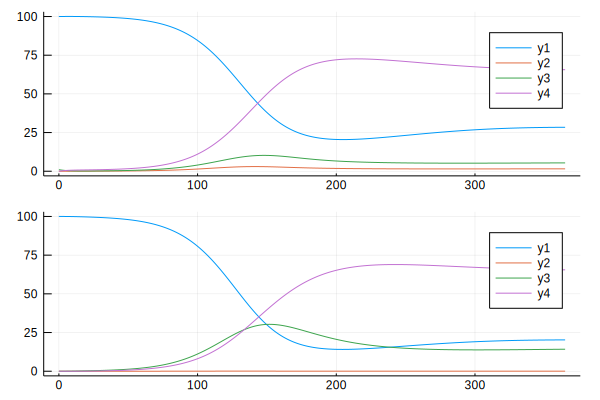

In [31]:
using Plots
host_1 = plot(df[:timestamp],[df[:,:S_H1],df[:,:E_H1],df[:,:I_H1],df[:,:R_H1]])
host_2 = plot(df[:timestamp],[df[:,:S_H2],df[:,:E_H2],df[:,:I_H2],df[:,:R_H2]])
plot(host_1,host_2,layout=(2,1))

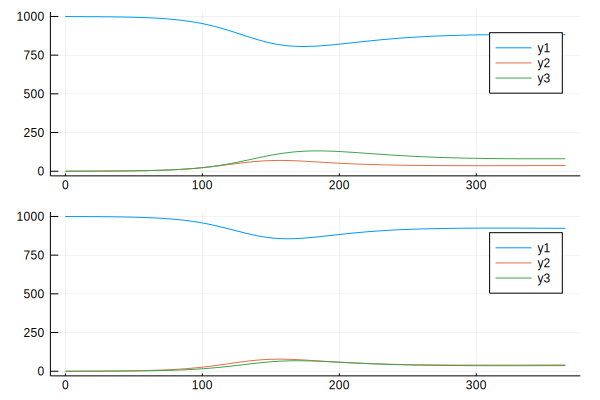

In [32]:
virus_1 = plot(df[:timestamp],[df[:,:S_V1],df[:,:E_V1],df[:,:I_V1]])
virus_2 = plot(df[:timestamp],[df[:,:S_V2],df[:,:E_V2],df[:,:I_V2]])
plot(virus_1,virus_2,layout=(2,1))